In [1]:
import fastfusion as ff
from math import log10

ff.set_n_parallel_jobs(32)

def get_runs(
    arch: str,
    workload: str,
    jinja_parse_data: dict,
    n_ranks: int,
    size: int,
):
    jinja_parse_data["M"] = size
    jinja_parse_data["KN"] = size

    spec = ff.Specification.from_yaml(arch, workload, jinja_parse_data=jinja_parse_data)

    workload = spec.workload
    for i in range(n_ranks - 3):
        workload.einsums["Matmul0"].tensor_accesses["W0"].projection[f"E{i}"] = f"e{i}"
        workload.shape[f"e{i}"] = f"0 <= e{i} < 1"

    spec.arch["ArrayDummy"].constraints.spatial["reuse_input"].min_utilization = 0
    spec.arch["ArrayDummy"].constraints.spatial["reuse_output"].min_utilization = 0
    spec.arch["MainMemory"].constraints.tensors.keep = "All"
    spec.arch["GlobalBuffer"].constraints.tensors.keep = "output | input | ~MainMemory"
    spec.arch["GlobalBuffer"].constraints.tensors.may_keep = "weight | ~MainMemory"
    if "tpu_v4i" in arch:
        # spec.arch["LocalBuffer"].constraints.spatial.append(ff.constraints.Spatial(name="Z", min_utilization=1))
        spec.arch["LocalBuffer"].constraints.tensors.keep = "input | output"

    spec.mapper.ffm.metrics = ff.Metrics.ENERGY | ff.Metrics.LATENCY

    print(spec.workload.shape)

    def run_mapper(spec: ff.Specification, count_option: str):
        spec.mapper.ffm._count_option_for_mapsapce_size_evaluation = count_option
        return ff.mapper.FFM.make_pmappings(spec, cache_dir="/tmp/ff_cache")

    normal = run_mapper(spec, ())
    total = run_mapper(spec, ("redundant_dataplacements", "non_helpful_loops_for_loop_orders", "non_helpful_tile_shapes", "redundant_loop_orders"))
    no_redundant_dataplacements = run_mapper(spec, ("non_helpful_loops_for_loop_orders", "non_helpful_tile_shapes", "redundant_loop_orders"))
    no_non_helpful_tile_shapes = run_mapper(spec, ("non_helpful_loops_for_loop_orders", "redundant_loop_orders"))
    no_non_helpful_loops_for_loop_orders = run_mapper(spec, ("redundant_loop_orders"))
    return (
        spec,
        normal,
        total,
        no_redundant_dataplacements,
        no_non_helpful_tile_shapes,
        no_non_helpful_loops_for_loop_orders,
    )

def get_reduction_per_piece(
    spec: ff.Specification,
    normal: ff.mapper.FFM.MultiEinsumPmappings,
    total: ff.mapper.FFM.MultiEinsumPmappings,
    no_redundant_dataplacements: ff.mapper.FFM.MultiEinsumPmappings,
    no_non_helpful_tile_shapes: ff.mapper.FFM.MultiEinsumPmappings,
    no_non_helpful_loops_for_loop_orders: ff.mapper.FFM.MultiEinsumPmappings,
):
    def _count(f):
        r = f(per_einsum=True)
        # r['Total'] = f()
        return r

    n_total = _count(total.n_total_pmappings)
    n_no_redundant_dataplacements = _count(no_redundant_dataplacements.n_total_pmappings)
    n_no_non_helpful_tile_shapes = _count(no_non_helpful_tile_shapes.n_total_pmappings)
    n_no_non_helpful_permutations = _count(normal.n_total_pmappings)
    n_ffm_evaluated = _count(normal.n_evaluated_pmappings)

    prev = [n_total]
    def get_reduction(to_mapspace, from_mapspace=None):
        if from_mapspace is None:
            from_mapspace = prev.pop(0)
            prev.append(to_mapspace)
        return {k: log10(max(v / to_mapspace[k], 1)) for k, v in from_mapspace.items()}

    redundant_dataplacements_reduction = get_reduction(n_no_redundant_dataplacements)
    non_helpful_tile_shapes_reduction = get_reduction(n_no_non_helpful_tile_shapes)
    redundant_loop_orders_reduction = get_reduction(n_no_non_helpful_permutations)
    pruned_tile_shapes_reduction = get_reduction(n_ffm_evaluated)
    remaining = get_reduction({k: 1 for k in n_total.keys()})

    print(redundant_dataplacements_reduction)
    print(non_helpful_tile_shapes_reduction)
    print(redundant_loop_orders_reduction)
    print(pruned_tile_shapes_reduction)

    non_helpful_tile_shapes_reduction = {
        k: v + redundant_dataplacements_reduction[k] for k, v in non_helpful_tile_shapes_reduction.items()
    }
    redundant_dataplacements_reduction = {
        k: 0 for k in n_total.keys()
    }

    einsums = [e.name for e in spec.workload.einsums if len(e.tensor_accesses) > 2]# + ["Total"]
    einsums = [e for e in einsums if e in remaining]

    return {
        e: {
            # "Dominated Dataplacements": redundant_dataplacements_reduction[e],
            "Loop Pruning": non_helpful_tile_shapes_reduction[e],
            "Dataflow Pruning": redundant_loop_orders_reduction[e],
            "Partial Tile Shape Pruning": pruned_tile_shapes_reduction[e],
        } for e in einsums
    }, total.n_total_pmappings(per_einsum=True), normal.n_evaluated_pmappings(per_einsum=True)


In [2]:
sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
results_size_unpruned = []
results_size_pruned = []
for size in sizes:
    reductions_gpt, totals_gpt, evaluated_gpt = get_reduction_per_piece(*get_runs(
        "../../examples/arches/tpu_v4i_like.arch.yaml",
        "../../examples/workloads/matmuls.workload.yaml",
        dict(M=size, KN=size, N_EINSUMS=1),
        3,
        size,
    ))
    results_size_unpruned.append(totals_gpt["Matmul0"])
    results_size_pruned.append(evaluated_gpt["Matmul0"])


size = 16384
n_rankss = [3, 4, 5, 6, 7, 8, 9, 10]
results_n_ranks_unpruned = []
results_n_ranks_pruned = []
for n_ranks in n_rankss:
    reductions_gpt, totals_gpt, evaluated_gpt = get_reduction_per_piece(*get_runs(
        "../../examples/arches/tpu_v4i_like.arch.yaml",
        "../../examples/workloads/matmuls.workload.yaml",
        dict(M=size, KN=size, N_EINSUMS=1),
        n_ranks,
        size,
    ))
    results_n_ranks_unpruned.append(totals_gpt["Matmul0"])
    results_n_ranks_pruned.append(evaluated_gpt["Matmul0"])

# import matplotlib.pyplot as plt
# from format_plot import format_plot

# def make_stacked_bar_chart(
#     results: dict[str, dict[str, float]],
#     ax: plt.Axes
# ):
#     categories = list(next(iter(results.values())).keys())
#     labels = list(results.keys())
#     data = list(zip(*results.values()))
#     bottom = [0] * len(labels)
#     for i, cat in enumerate(categories):
#         ax.bar(labels, [results[l][cat] for l in labels], label=cat, bottom=bottom)
#         bottom = [b + v for b, v in zip(bottom, [results[l][cat] for l in labels])]
#     format_plot(ax)
#     # Set the Y axis label to be 10^x
#     ax.set_yticklabels([f"$10^{{{int(y)}}}$" for y in ax.get_yticks()])
#     ax.set_xticklabels(labels, rotation=45, ha="right")


# reductions_gpt, totals_gpt, evaluated_gpt = get_reduction_per_piece(*get_runs(
#     "../../examples/arches/tpu_v4i_like.arch.yaml",
#     "../../examples/workloads/gpt3_6.7B.workload.yaml",
#     dict(BATCH_SIZE=64, N_TOKENS=65536),
# ))

# # reductions_gpt_b1 = get_reduction_per_piece(*get_runs(
# #     "../../examples/arches/tpu_v4i_like.arch.yaml",
# #     "../../examples/workloads/gpt3_6.7B.workload.yaml",
# #     dict(BATCH_SIZE=1, N_TOKENS=65536),
# # ))

# ff.set_n_parallel_jobs(32)
# reductions_mobilenet, totals_mobilenet, evaluated_mobilenet = get_reduction_per_piece(*get_runs(
#     "../../examples/arches/nvdla_like.arch.yaml",
#     "../../examples/workloads/mobilenet_28.workload.yaml",
#     dict(BATCH_SIZE=64),
# ))

# # reductions_mobilenet_b1 = get_reduction_per_piece(*get_runs(
# #     "../../examples/arches/nvdla_like.arch.yaml",
# #     "../../examples/workloads/mobilenet_28.workload.yaml",
# #     dict(BATCH_SIZE=1),
# # ))

# # fig, ax = plt.subplots(figsize=(20, 10))
# # make_stacked_bar_chart(reductions_gpt, ax)
# # ax.set_title(f"TPU-like, GPT-3 6.7B")
# # ax.set_ylabel(f"Reduction in #Mappings")
# # plt.show()

# # fig, ax = plt.subplots(figsize=(20, 10))
# # make_stacked_bar_chart(reductions_mobilenet, ax)
# # ax.set_title(f"NVDLA-like, MobileNet-v3")
# # ax.set_ylabel(f"Reduction in #Mappings")
# # plt.show()


WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


{'m': '0 <= m  < 128', 'n': '0 <= n < 128', 'k': '0 <= k < 128'}
Matmul0: 4.65e07 total, 3.78e07 (1/1) valid, 6.35e05 (1/73) evaluated, 2 (1/2.33e07) Pareto-Optimal
Total: 4.65e07 total, 3.78e07 (1/1) valid, 6.35e05 (1/73) evaluated, 2 (1/2.33e07) Pareto-Optimal
Matmul0: 3.24e17 total, 9.43e09 (1/3.44e07) valid, 0 (1/inf) evaluated, 1 (1/3.24e17) Pareto-Optimal
Total: 3.24e17 total, 9.43e09 (1/3.44e07) valid, 0 (1/inf) evaluated, 1 (1/3.24e17) Pareto-Optimal
Matmul0: 3.24e17 total, 9.43e09 (1/3.44e07) valid, 0 (1/inf) evaluated, 1 (1/3.24e17) Pareto-Optimal
Total: 3.24e17 total, 9.43e09 (1/3.44e07) valid, 0 (1/inf) evaluated, 1 (1/3.24e17) Pareto-Optimal
Matmul0: 1.06e13 total, 9.43e09 (1/1.12e03) valid, 0 (1/inf) evaluated, 1 (1/1.06e13) Pareto-Optimal
Total: 1.06e13 total, 9.43e09 (1/1.12e03) valid, 0 (1/inf) evaluated, 1 (1/1.06e13) Pareto-Optimal


WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 9.31e07 total, 9.43e09 (1/0) valid, 0 (1/inf) evaluated, 1 (1/9.31e07) Pareto-Optimal
Total: 9.31e07 total, 9.43e09 (1/0) valid, 0 (1/inf) evaluated, 1 (1/9.31e07) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 4.484705085958187}
{'Matmul0': 5.3578885989905976}
{'Matmul0': 1.8647998221893}
{'m': '0 <= m  < 256', 'n': '0 <= n < 256', 'k': '0 <= k < 256'}
Matmul0: 1.29e08 total, 8.71e07 (1/1) valid, 1.06e06 (1/121) evaluated, 3 (1/4.30e07) Pareto-Optimal
Total: 1.29e08 total, 8.71e07 (1/1) valid, 1.06e06 (1/121) evaluated, 3 (1/4.30e07) Pareto-Optimal
Matmul0: 2.42e18 total, 3.03e10 (1/7.99e07) valid, 0 (1/inf) evaluated, 1 (1/2.42e18) Pareto-Optimal
Total: 2.42e18 total, 3.03e10 (1/7.99e07) valid, 0 (1/inf) evaluated, 1 (1/2.42e18) Pareto-Optimal
Matmul0: 2.42e18 total, 3.03e10 (1/7.99e07) valid, 0 (1/inf) evaluated, 1 (1/2.42e18) Pareto-Optimal
Total: 2.42e18 total, 3.03e10 (1/7.99e07) valid, 0 (1/inf) evaluated, 1 (1/2.42e18) Pareto-Optimal
Matmul0: 2.99e13 total, 3.03e10 (1/988

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 2.58e08 total, 3.03e10 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.58e08) Pareto-Optimal
Total: 2.58e08 total, 3.03e10 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.58e08) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 4.908031640668072}
{'Matmul0': 5.365396604723431}
{'Matmul0': 2.084436911714629}
{'m': '0 <= m  < 512', 'n': '0 <= n < 512', 'k': '0 <= k < 512'}
Matmul0: 3.25e08 total, 1.73e08 (1/2) valid, 1.66e06 (1/196) evaluated, 3 (1/1.08e08) Pareto-Optimal
Total: 3.25e08 total, 1.73e08 (1/2) valid, 1.66e06 (1/196) evaluated, 3 (1/1.08e08) Pareto-Optimal
Matmul0: 1.53e19 total, 8.62e10 (1/1.78e08) valid, 0 (1/inf) evaluated, 1 (1/1.53e19) Pareto-Optimal
Total: 1.53e19 total, 8.62e10 (1/1.78e08) valid, 0 (1/inf) evaluated, 1 (1/1.53e19) Pareto-Optimal
Matmul0: 1.53e19 total, 8.62e10 (1/1.78e08) valid, 0 (1/inf) evaluated, 1 (1/1.53e19) Pareto-Optimal
Total: 1.53e19 total, 8.62e10 (1/1.78e08) valid, 0 (1/inf) evaluated, 1 (1/1.53e19) Pareto-Optimal
Matmul0: 7.65e13 total, 8.62e10 (1/88

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 6.50e08 total, 8.62e10 (1/0) valid, 0 (1/inf) evaluated, 1 (1/6.50e08) Pareto-Optimal
Total: 6.50e08 total, 8.62e10 (1/0) valid, 0 (1/inf) evaluated, 1 (1/6.50e08) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 5.30163979928989}
{'Matmul0': 5.371742385724925}
{'Matmul0': 2.291284935087429}
{'m': '0 <= m  < 1024', 'n': '0 <= n < 1024', 'k': '0 <= k < 1024'}
Matmul0: 7.57e08 total, 3.61e08 (1/2) valid, 2.40e06 (1/315) evaluated, 3 (1/2.52e08) Pareto-Optimal
Total: 7.57e08 total, 3.61e08 (1/2) valid, 2.40e06 (1/315) evaluated, 3 (1/2.52e08) Pareto-Optimal
Matmul0: 8.42e19 total, 2.22e11 (1/3.79e08) valid, 0 (1/inf) evaluated, 1 (1/8.42e19) Pareto-Optimal
Total: 8.42e19 total, 2.22e11 (1/3.79e08) valid, 0 (1/inf) evaluated, 1 (1/8.42e19) Pareto-Optimal
Matmul0: 8.42e19 total, 2.22e11 (1/3.79e08) valid, 0 (1/inf) evaluated, 1 (1/8.42e19) Pareto-Optimal
Total: 8.42e19 total, 2.22e11 (1/3.79e08) valid, 0 (1/inf) evaluated, 1 (1/8.42e19) Pareto-Optimal
Matmul0: 1.80e14 total, 2.22e11 (1/

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.51e09 total, 2.22e11 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.51e09) Pareto-Optimal
Total: 1.51e09 total, 2.22e11 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.51e09) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 5.669450716276444}
{'Matmul0': 5.377175779195449}
{'Matmul0': 2.4988923095648046}
{'m': '0 <= m  < 2048', 'n': '0 <= n < 2048', 'k': '0 <= k < 2048'}
Matmul0: 1.65e09 total, 4.45e08 (1/4) valid, 2.02e06 (1/814) evaluated, 3 (1/5.49e08) Pareto-Optimal
Total: 1.65e09 total, 4.45e08 (1/4) valid, 2.02e06 (1/814) evaluated, 3 (1/5.49e08) Pareto-Optimal
Matmul0: 4.11e20 total, 5.27e11 (1/7.79e08) valid, 0 (1/inf) evaluated, 1 (1/4.11e20) Pareto-Optimal
Total: 4.11e20 total, 5.27e11 (1/7.79e08) valid, 0 (1/inf) evaluated, 1 (1/4.11e20) Pareto-Optimal
Matmul0: 4.11e20 total, 5.27e11 (1/7.79e08) valid, 0 (1/inf) evaluated, 1 (1/4.11e20) Pareto-Optimal
Total: 4.11e20 total, 5.27e11 (1/7.79e08) valid, 0 (1/inf) evaluated, 1 (1/4.11e20) Pareto-Optimal
Matmul0: 3.97e14 total, 5.27e11 (

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 3.30e09 total, 5.27e11 (1/0) valid, 0 (1/inf) evaluated, 1 (1/3.30e09) Pareto-Optimal
Total: 3.30e09 total, 5.27e11 (1/0) valid, 0 (1/inf) evaluated, 1 (1/3.30e09) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.014653473204911}
{'Matmul0': 5.381879935035948}
{'Matmul0': 2.9107368717835245}
{'m': '0 <= m  < 4096', 'n': '0 <= n < 4096', 'k': '0 <= k < 4096'}
Matmul0: 3.39e09 total, 7.89e08 (1/4) valid, 2.83e06 (1/1.20e03) evaluated, 1 (1/3.39e09) Pareto-Optimal
Total: 3.39e09 total, 7.89e08 (1/4) valid, 2.83e06 (1/1.20e03) evaluated, 1 (1/3.39e09) Pareto-Optimal
Matmul0: 1.80e21 total, 1.17e12 (1/1.54e09) valid, 0 (1/inf) evaluated, 1 (1/1.80e21) Pareto-Optimal
Total: 1.80e21 total, 1.17e12 (1/1.54e09) valid, 0 (1/inf) evaluated, 1 (1/1.80e21) Pareto-Optimal
Matmul0: 1.80e21 total, 1.17e12 (1/1.54e09) valid, 0 (1/inf) evaluated, 1 (1/1.80e21) Pareto-Optimal
Total: 1.80e21 total, 1.17e12 (1/1.54e09) valid, 0 (1/inf) evaluated, 1 (1/1.80e21) Pareto-Optimal
Matmul0: 8.25e14 total, 1

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 6.78e09 total, 1.17e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/6.78e09) Pareto-Optimal
Total: 6.78e09 total, 1.17e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/6.78e09) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.339877603915309}
{'Matmul0': 5.385992141666258}
{'Matmul0': 3.0788790930270475}
{'m': '0 <= m  < 8192', 'n': '0 <= n < 8192', 'k': '0 <= k < 8192'}
Matmul0: 6.64e09 total, 1.32e09 (1/5) valid, 3.92e06 (1/1.70e03) evaluated, 1 (1/6.64e09) Pareto-Optimal
Total: 6.64e09 total, 1.32e09 (1/5) valid, 3.92e06 (1/1.70e03) evaluated, 1 (1/6.64e09) Pareto-Optimal
Matmul0: 7.23e21 total, 2.44e12 (1/2.96e09) valid, 0 (1/inf) evaluated, 1 (1/7.23e21) Pareto-Optimal
Total: 7.23e21 total, 2.44e12 (1/2.96e09) valid, 0 (1/inf) evaluated, 1 (1/7.23e21) Pareto-Optimal
Matmul0: 7.23e21 total, 2.44e12 (1/2.96e09) valid, 0 (1/inf) evaluated, 1 (1/7.23e21) Pareto-Optimal
Total: 7.23e21 total, 2.44e12 (1/2.96e09) valid, 0 (1/inf) evaluated, 1 (1/7.23e21) Pareto-Optimal
Matmul0: 1.63e15 total, 2

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.33e10 total, 2.44e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.33e10) Pareto-Optimal
Total: 1.33e10 total, 2.44e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.33e10) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.647317348512163}
{'Matmul0': 5.389617315405582}
{'Matmul0': 3.2294881781269673}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384'}
Matmul0: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Total: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Matmul0: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Total: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Matmul0: 3.08e15 total

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 2.50e10 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.50e10) Pareto-Optimal
Total: 2.50e10 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.50e10) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.938823073616401}
{'Matmul0': 5.392836998510448}
{'Matmul0': 3.330912458562444}
{'m': '0 <= m  < 32768', 'n': '0 <= n < 32768', 'k': '0 <= k < 32768'}
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=0, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 614e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True)

Generating pmapping templates for compute ScalarUnit Einsum Matmul0: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum Matmul0: 16it [00:00, 75.62it/s]
Generating jobs: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]
WARNING Einsum Matmul0 has 16 pmapping templates:
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] T-k  S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] S-Z-k,m,n  [T1 in LocalBuffer] T-k  [T0 in LocalBuffer] T-n  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-m,n  [T1 in GlobalBuffer] T-k  [T0 in GlobalBuffer] S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainM

___________________________________________make_pmappings_cached - 47.6s, 0.8min
Matmul0: 2.26e10 total, 2.65e09 (1/9) valid, 7.46e06 (1/3.02e03) evaluated, 3 (1/7.52e09) Pareto-Optimal
Total: 2.26e10 total, 2.65e09 (1/9) valid, 7.46e06 (1/3.02e03) evaluated, 3 (1/7.52e09) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=0, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 614e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_boun

Generating pmapping templates for compute ScalarUnit Einsum Matmul0: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum Matmul0: 16it [00:00, 74.52it/s]
Generating jobs: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
WARNING Einsum Matmul0 has 16 pmapping templates:
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] T-k  S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] S-Z-k,m,n  [T1 in LocalBuffer] T-k  [T0 in LocalBuffer] T-n  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-m,n  [T1 in GlobalBuffer] T-k  [T0 in GlobalBuffer] S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainM

____________________________________________make_pmappings_cached - 5.8s, 0.1min
Matmul0: 9.23e22 total, 9.22e12 (1/1.00e10) valid, 0 (1/inf) evaluated, 1 (1/9.23e22) Pareto-Optimal
Total: 9.23e22 total, 9.22e12 (1/1.00e10) valid, 0 (1/inf) evaluated, 1 (1/9.23e22) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=0, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 614e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], r

Generating pmapping templates for compute ScalarUnit Einsum Matmul0: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum Matmul0: 16it [00:00, 72.60it/s]
Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]
WARNING Einsum Matmul0 has 16 pmapping templates:
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] T-k  S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] S-Z-k,m,n  [T1 in LocalBuffer] T-k  [T0 in LocalBuffer] T-n  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-m,n  [T1 in GlobalBuffer] T-k  [T0 in GlobalBuffer] S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainM

____________________________________________make_pmappings_cached - 4.2s, 0.1min
Matmul0: 9.23e22 total, 9.22e12 (1/1.00e10) valid, 0 (1/inf) evaluated, 1 (1/9.23e22) Pareto-Optimal
Total: 9.23e22 total, 9.22e12 (1/1.00e10) valid, 0 (1/inf) evaluated, 1 (1/9.23e22) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=0, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 614e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], r

Generating pmapping templates for compute ScalarUnit Einsum Matmul0: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum Matmul0: 16it [00:00, 53.85it/s]
Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]
WARNING Einsum Matmul0 has 16 pmapping templates:
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] T-k  S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] S-Z-k,m,n  [T1 in LocalBuffer] T-k  [T0 in LocalBuffer] T-n  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-m,n  [T1 in GlobalBuffer] T-k  [T0 in GlobalBuffer] S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainM

____________________________________________make_pmappings_cached - 4.1s, 0.1min
Matmul0: 5.61e15 total, 9.22e12 (1/609) valid, 0 (1/inf) evaluated, 1 (1/5.61e15) Pareto-Optimal
Total: 5.61e15 total, 9.22e12 (1/609) valid, 0 (1/inf) evaluated, 1 (1/5.61e15) Pareto-Optimal
________________________________________________________________________________
[Memory] Calling fastfusion.mapper.FFM.main.make_pmappings.<locals>._make_pmappings_cached...
_make_pmappings_cached(spec=Specification(type=None, arch=Arch(type=None, nodes=ArchNodes([Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=0, leak_power=0, leak_power_scale=1, latency='(read_actions + write_actions) / (8 * 614e9)', datawidth={'All()': 8}, size='inf'), spatial=[], constraints=ConstraintGroup(type=None, name=None, misc=Misc(type=None, enabled=True), spatial=[], temporal=Temporal(type=None, version='0.5', reuse='All', loop_bounds=[], rmw_first

Generating pmapping templates for compute ScalarUnit Einsum Matmul0: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum Matmul0: 16it [00:00, 46.72it/s]
Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]
WARNING Einsum Matmul0 has 16 pmapping templates:
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] T-k  S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-k,m  [T0 in GlobalBuffer] T-n  [T1 in GlobalBuffer] S-Z-k,m,n  [T1 in LocalBuffer] T-k  [T0 in LocalBuffer] T-n  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainMemory] T-m,n  [T1 in GlobalBuffer] T-k  [T0 in GlobalBuffer] S-Z-k,m,n  [T0 in LocalBuffer] T-n  [T1 in LocalBuffer] T-k  S-reuse_output-k  S-reuse_input-n  [W0 in Register] T-m  MAC computes Matmul0
WARNING 	[W0,T1,T0 in MainM

____________________________________________make_pmappings_cached - 3.7s, 0.1min
Matmul0: 4.51e10 total, 9.22e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/4.51e10) Pareto-Optimal
Total: 4.51e10 total, 9.22e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/4.51e10) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 7.215969796282776}
{'Matmul0': 5.395715517185072}
{'Matmul0': 3.480714100329169}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384'}
Matmul0: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Total: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Matmul0: 2.68e22 total, 4.85e12 (1/5.52e09) valid, 0 (1/inf) evaluated, 1 (1/2.68e22) Pareto-Optimal
Total: 2.68e22 total, 4.85e12 (1/5.52e09)

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 2.50e10 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.50e10) Pareto-Optimal
Total: 2.50e10 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/2.50e10) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.938823073616401}
{'Matmul0': 5.392836998510448}
{'Matmul0': 3.330912458562444}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1'}
Matmul0: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 4.37e26 total, 4.85e12 (1/9.01e13) valid, 0 (1/inf) evaluated, 1 (1/4.37e26) Pareto-Optimal
Total: 4.37e26 total, 4.85e12 (1/9.01e13) valid, 0 (1/inf) evaluated, 1 (1/4.37e26) Pareto-Optimal
Matmul0: 4.37e26 total, 4.85e12 (1/9.01e13) valid, 0 (1/inf) evaluated, 1 (1/4.37e26) Pareto-Optimal
Total: 4.37e26 total, 4.85e12 (1/9.01e13) valid, 0 (1/inf) evaluated, 1 (1/4.37e26) Pareto-Optimal
Ma

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.08e11 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.08e11) Pareto-Optimal
Total: 1.08e11 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.08e11) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.945246177884922}
{'Matmul0': 9.599041254018777}
{'Matmul0': 3.330957508735397}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1', 'e1': '0 <= e1 < 1'}
Matmul0: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 3.41e31 total, 4.85e12 (1/7.03e18) valid, 0 (1/inf) evaluated, 1 (1/3.41e31) Pareto-Optimal
Total: 3.41e31 total, 4.85e12 (1/7.03e18) valid, 0 (1/inf) evaluated, 1 (1/3.41e31) Pareto-Optimal
Matmul0: 3.41e31 total, 4.85e12 (1/7.03e18) valid, 0 (1/inf) evaluated, 1 (1/3.41e31) Pareto-Optimal
Total: 3.41e31 total, 4.85e12 (1/7.03e18) valid, 0 (1/inf) evaluated, 1 (1/3.41e

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.06e12 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.06e12) Pareto-Optimal
Total: 1.06e12 total, 4.85e12 (1/0) valid, 0 (1/inf) evaluated, 1 (1/1.06e12) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.946961437996618}
{'Matmul0': 14.489637592487576}
{'Matmul0': 3.330929612878693}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1', 'e1': '0 <= e1 < 1', 'e2': '0 <= e2 < 1'}
Matmul0: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 9.54e36 total, 4.85e12 (1/1.97e24) valid, 0 (1/inf) evaluated, 1 (1/9.54e36) Pareto-Optimal
Total: 9.54e36 total, 4.85e12 (1/1.97e24) valid, 0 (1/inf) evaluated, 1 (1/9.54e36) Pareto-Optimal
Matmul0: 9.54e36 total, 4.85e12 (1/1.97e24) valid, 0 (1/inf) evaluated, 1 (1/9.54e36) Pareto-Optimal
Total: 9.54e36 total, 4.85e12 (1/1.97e24) valid, 0 (1/inf)

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.84e13 total, 4.85e12 (1/4) valid, 0 (1/inf) evaluated, 1 (1/1.84e13) Pareto-Optimal
Total: 1.84e13 total, 4.85e12 (1/4) valid, 0 (1/inf) evaluated, 1 (1/1.84e13) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.947318904841579}
{'Matmul0': 19.936239183285394}
{'Matmul0': 3.330932074205739}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1', 'e1': '0 <= e1 < 1', 'e2': '0 <= e2 < 1', 'e3': '0 <= e3 < 1'}
Matmul0: 1.25e10 total, 1.81e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.81e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 7.86e42 total, 4.85e12 (1/1.62e30) valid, 0 (1/inf) evaluated, 1 (1/7.86e42) Pareto-Optimal
Total: 7.86e42 total, 4.85e12 (1/1.62e30) valid, 0 (1/inf) evaluated, 1 (1/7.86e42) Pareto-Optimal
Matmul0: 7.86e42 total, 4.85e12 (1/1.62e30) valid, 0 (1/inf) evaluated, 1 (1/7.86e42) Pareto-Optimal
Total: 7.86e42 total, 4.85e12 (1/1.62

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 5.00e14 total, 4.85e12 (1/103) valid, 0 (1/inf) evaluated, 1 (1/5.00e14) Pareto-Optimal
Total: 5.00e14 total, 4.85e12 (1/103) valid, 0 (1/inf) evaluated, 1 (1/5.00e14) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.947380188990923}
{'Matmul0': 25.85184708790381}
{'Matmul0': 3.3309472899916863}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1', 'e1': '0 <= e1 < 1', 'e2': '0 <= e2 < 1', 'e3': '0 <= e3 < 1', 'e4': '0 <= e4 < 1'}
Matmul0: 1.25e10 total, 1.81e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.81e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 1.65e49 total, 4.85e12 (1/3.40e36) valid, 0 (1/inf) evaluated, 1 (1/1.65e49) Pareto-Optimal
Total: 1.65e49 total, 4.85e12 (1/3.40e36) valid, 0 (1/inf) evaluated, 1 (1/1.65e49) Pareto-Optimal
Matmul0: 1.65e49 total, 4.85e12 (1/3.40e36) valid, 0 (1/inf) evaluated, 1 (1/1.65e49) Pareto-Optimal
Total: 1.65e

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.94e16 total, 4.85e12 (1/4.00e03) valid, 0 (1/inf) evaluated, 1 (1/1.94e16) Pareto-Optimal
Total: 1.94e16 total, 4.85e12 (1/4.00e03) valid, 0 (1/inf) evaluated, 1 (1/1.94e16) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.947389126363077}
{'Matmul0': 32.17346556697092}
{'Matmul0': 3.3309475137572218}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1', 'e1': '0 <= e1 < 1', 'e2': '0 <= e2 < 1', 'e3': '0 <= e3 < 1', 'e4': '0 <= e4 < 1', 'e5': '0 <= e5 < 1'}
Matmul0: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.80e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 7.88e55 total, 4.85e12 (1/1.63e43) valid, 0 (1/inf) evaluated, 1 (1/7.88e55) Pareto-Optimal
Total: 7.88e55 total, 4.85e12 (1/1.63e43) valid, 0 (1/inf) evaluated, 1 (1/7.88e55) Pareto-Optimal
Matmul0: 7.88e55 total, 4.85e12 (1/1.63e43) valid, 0 (1/inf) evaluated, 1 (1/7.88e55

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Matmul0: 1.02e18 total, 4.85e12 (1/2.11e05) valid, 0 (1/inf) evaluated, 1 (1/1.02e18) Pareto-Optimal
Total: 1.02e18 total, 4.85e12 (1/2.11e05) valid, 0 (1/inf) evaluated, 1 (1/1.02e18) Pareto-Optimal
{'Matmul0': 0.0}
{'Matmul0': 6.947390261269304}
{'Matmul0': 38.85316168163114}
{'Matmul0': 3.330988912365037}
{'m': '0 <= m  < 16384', 'n': '0 <= n < 16384', 'k': '0 <= k < 16384', 'e0': '0 <= e0 < 1', 'e1': '0 <= e1 < 1', 'e2': '0 <= e2 < 1', 'e3': '0 <= e3 < 1', 'e4': '0 <= e4 < 1', 'e5': '0 <= e5 < 1', 'e6': '0 <= e6 < 1'}
Matmul0: 1.25e10 total, 1.81e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Total: 1.25e10 total, 1.81e09 (1/7) valid, 5.82e06 (1/2.14e03) evaluated, 2 (1/6.24e09) Pareto-Optimal
Matmul0: 7.88e62 total, 4.85e12 (1/1.63e50) valid, 0 (1/inf) evaluated, 1 (1/7.88e62) Pareto-Optimal
Total: 7.88e62 total, 4.85e12 (1/1.63e50) valid, 0 (1/inf) evaluated, 1 (1/7.88e62) Pareto-Optimal
Matmul0: 7.88e62 total, 4.85e12 (1/1.63e50) valid, 0 (1/inf) eva

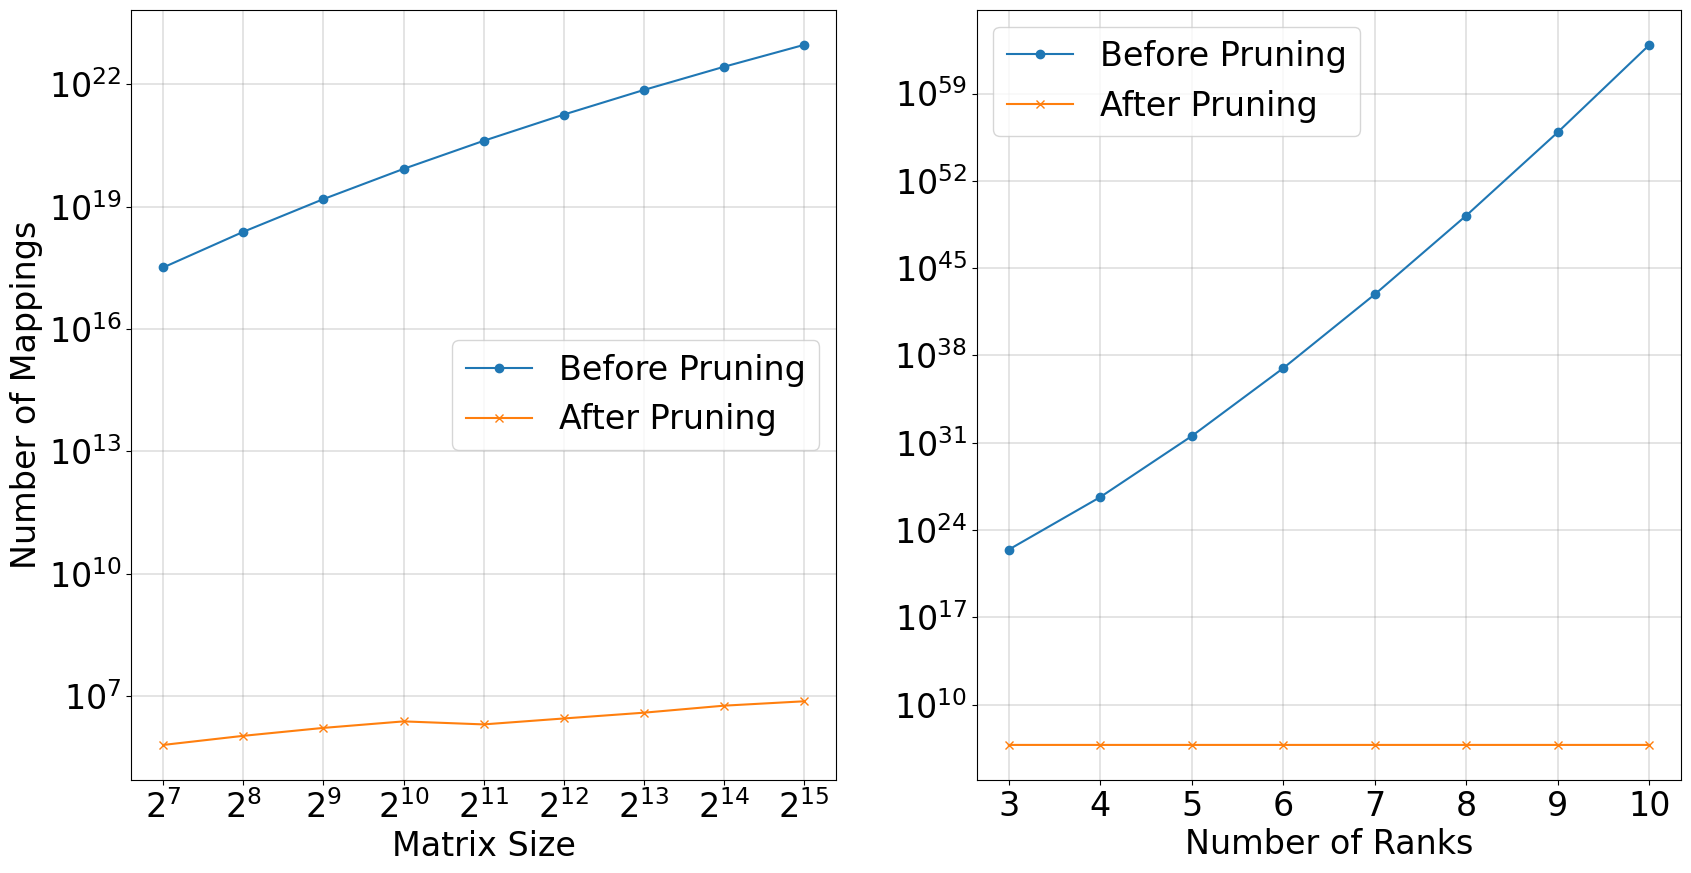

In [18]:
from math import log2

# Plot with number of mappings on the Y axis. Show pre and post pruning. Make it a line
# plot.
import matplotlib.pyplot as plt
from format_plot import format_plot
fig, axs = plt.subplots(figsize=(20, 10), ncols=2)
ax = axs[0]
str_sizes = [f"$2^{{{round(log2(s))}}}$" for s in sizes]
ax.plot(str_sizes, results_size_unpruned, label="Before Pruning", marker="o")
ax.plot(str_sizes, results_size_pruned, label="After Pruning", marker="x")
ax.grid(axis='both', which='major', linestyle='-', linewidth='0.3', color='gray')
ax.grid(axis='both', which='minor', linestyle='--', linewidth='0.1', color='lightgray')
ax.set_yscale("log")
ax.set_ylabel("Number of Mappings")
ax.set_xlabel("Matrix Size")
ax.set_xticks(str_sizes)
ax.set_xticklabels(str_sizes)
ax.legend()

ax = axs[1]
ax.plot(n_rankss, results_n_ranks_unpruned, label="Before Pruning", marker="o")
ax.plot(n_rankss, results_n_ranks_pruned, label="After Pruning", marker="x")
# ax.minorticks_on()
ax.grid(axis='both', which='major', linestyle='-', linewidth='0.3', color='gray')
ax.grid(axis='both', which='minor', linestyle='--', linewidth='0.1', color='lightgray')
ax.set_yscale("log")
# ax.set_ylabel("Number of mappings")
ax.set_xlabel("Number of Ranks")
ax.set_xticks(n_rankss)
ax.set_xticklabels(n_rankss)
ax.legend()

plt.savefig("outputs/plots/pruning_rate_scaling.pdf", bbox_inches="tight")
plt.show()